# Modified Weather Bench Code

This code is largely (90%++) from ECMWF codw https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/weatherbench.ipynb

This original code is shared under a Apache-2.0 license. 

While this project is a simple example of deep learning using xarray datasets, I might do some things differently. Feel free to book a meeting with me (Thomas Martin) anytime. 

# Simple example of a WeatherBench model

In this notebook we will build a simple neural network on the WeatherBench dataset. We will walk you through all the code so if you are not familiar with python you can simply click through the code boxes (see "How to run this exercise" below). If you are familiar with python and machine learning, there is a stretch exercise at the end of the notebook.

The aim of this example is to predict the geopotential at the 500hPa pressure level in the atmosphere and compare your solution with the benchmark dataset. This variable is important for identifying weather systems such as cyclones and anticyclones.

With the data you will download, you can make a forecast for any number of days ahead, but in this exercise we focus on forecasting the geopotential five days ahead.

We evaluate our model using the Root Mean Squared Error.

## How to run this exercise

This exercise is in the form of a [Jupyter notebook](https://jupyter.org/). It can be "run" in a number of free cloud based environments (see two options below). These require no installation. When you click on one of the links below ("Open in Colab" or "Open in Kaggle") you will be prompted to create a free account, after which you will see the same page you see here. Follow the instructions below to connect to a GPU. After that you can run each block of code by selecting shift+control repeatedly, or by selecting the "play" icon. 

Advanced users may wish to run this exercise on their own computers by first installing Python and Jupyter, in addition to the packages listed below (xarray, numpy and tensorflow), or as listed in the "environment.yml" file in https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/tree/main/tier_1.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/weatherbench.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_1/weatherbench.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
  </tr>
</table>

Note that to use Kaggle, you need to enable an option on the notebook. Please follow the instructions here to do this https://stackoverflow.com/questions/68142524/cannot-access-internet-on-kaggle-notebook. 

Since we will train a neural network later, it might make sense to connect to a GPU runtime:

*   In Google Colab this can be done under Runtime --> Change runtime type.

*   In Kaggle this can be done under Accelerator.

## Import packages

Below is the very first code block to "run". This will import software packages needed to run the exercise. They include [numpy](https://numpy.org/doc/stable/) and [xarray](https://docs.xarray.dev/en/stable/), which are used for handling multidimentional arrays of data. They also include [tensorflow](https://www.tensorflow.org/) which is a popular Machine Learning package.

In [1]:
import sys

# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Load in the necessary python packages to train a neural network

import keras
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, ELU

2024-01-31 20:29:21.583977: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 20:29:21.584026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 20:29:21.584050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 20:29:21.590382: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from keras.callbacks import EarlyStopping

In [3]:
print(f"Python version: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version: 2.14.0
Keras version: 3.0.2


In [4]:
# Set the device for TensorFlow operations
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"

# Optionally, set the default device for subsequent operations
tf.device(device)

# Print information about the device
if device == "/GPU:0":
    print("Training on GPU!")
else:
    print("Training on CPU.")

Training on GPU!


2024-01-31 20:29:23.273189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 20:29:23.278597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 20:29:23.278745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Download data

We need to download the WeatherBench data from the public repository. We will only download the 500hPa geopotential data at 5.625 degrees, because training on the whole benchmark dataset using colab would take a very long time and is thus beyond the scope of this exercise. 

#### Note this download may take over 20 minutes.

In [5]:
#try:
#    !wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/geopotential_500_5.625deg.zip
#except:
#    !wget --no-check-certificate "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

In [6]:
# Unzip the data
#!unzip geopotential_500_5.625deg.zip

Next we open the dataset using xarray. We will also, for the sake of speed and simplicity, load data only every 12 hours.

In [7]:
z500 = xr.open_mfdataset('geopotential_500*.nc', combine='by_coords').isel(time=slice(None, None, 12))
z500

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 29220)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [8]:
# Now we can load the data into memory to speed up accessing data. This should take <30s
z500.load()

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 29220)
Coordinates:
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 5.156e+04 5.158e+04 ... 4.864e+04
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

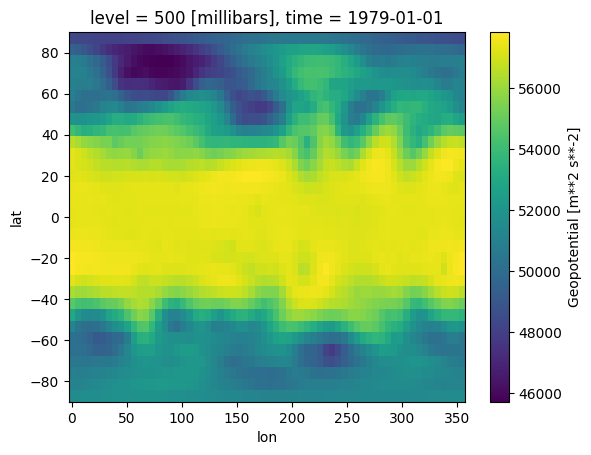

In [9]:
# Plot the geopotential at an example date-time
z500.z.isel(time=0).plot();

## Compute baselines

Before training an ML model it is important to have some baselines. Here, we will compute a climatology baseline. For this, we will use the training time period (1979 to 2015) and compute a climatology for each day of the year. 

In [10]:
# training dataset selection
train_years = slice('1979', '2015')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2016', '2016')
# test dataset selection
test_years = slice('2017', '2018')

In [11]:
def computed_weighted_rmse(fc, gt):
  """Error metric to compute the area averaged RMSE."""
  error = fc - gt
  weights_lat = np.cos(np.deg2rad(error.lat))
  weights_lat /= weights_lat.mean()
  rmse = np.sqrt(((error)**2 * weights_lat).mean(('time', 'lat', 'lon')))
  return rmse

Here we consider two baselines: the persistence and the climatology. The persistence is calculated as follows:

In [12]:
# pick the forecast lead time
lead_time_steps = 10 # 5 day forecast because considering midday and midnight

# compute persistent forecast 
persistence_fc = z500.sel(time=test_years).isel(time=slice(0, -lead_time_steps))
persistence_fc['time'] = persistence_fc.time + np.timedelta64(5, 'D').astype('timedelta64[ns]')

# target data
target = z500.sel(time=test_years)['z']
# compute RMSE
computed_weighted_rmse(persistence_fc, target)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 1.034e+03

The climatology is calculated for each day of year from the training time period

In [13]:
clim = z500.sel(time=train_years).groupby('time.dayofyear').mean()
# compute RMSE
computed_weighted_rmse(clim.sel(dayofyear=z500.sel(time=test_years).time.dt.dayofyear), z500)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 819.9

## Train a simple ML model

Now we can train a simple convolutional neural network. We will use Keras for this. First though we need to prepare the data.

In [14]:
def get_train_valid_test_dataset(lead_steps, z500_dataset):
  # Split train, valid and test dataset
  train_data = z500_dataset.sel(time=train_years)
  valid_data = z500_dataset.sel(time=valid_years)
  test_data = z500_dataset.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  mean = mean['z'].values # extract numerical value from xarray Dataset
  std = std['z'].values # extract numerical value from xarray Dataset

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data.z.isel(time=slice(lead_steps, None)).values[..., None]  
  X_test = test_data.z.isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data.z.isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [15]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, z500)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(27018, 32, 64, 1)
(27018, 32, 64, 1)
(722, 32, 64, 1)
(722, 32, 64, 1)
(1450, 32, 64, 1)
(1450, 32, 64, 1)


### Build model

Next we will build the model using Keras. There are many guides for Keras out there, for example [this](https://keras.io/examples/vision/mnist_convnet/). Here we will build a convolutional neural network which we briefly discussed at the end of the module

## Three models are below

To use a different one, just uncomment it. 

What are different about them? Which one performs the best? Are they all CNN's?

In [16]:
#model = keras.Sequential([
#    keras.layers.Conv2D(32, 5, padding='same'),   # 32 channels with a 5x5 convolution
#    keras.layers.ELU(),  # Slightly smoother alternative to ReLU
#    keras.layers.Conv2D(32, 5, padding='same'),   # Same padding keeps the size identical.
#    keras.layers.ELU(),
#    keras.layers.Conv2D(1, 5, padding='same'),
    # No activation since we are solving a regression problem
#])

In [17]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding="same"), # Start with smaller filter size (3x3) for broader feature capture
    keras.layers.ELU(),
    keras.layers.Dropout(0.2), # Introduce first dropout layer to prevent overfitting
    keras.layers.Conv2D(64, (5, 5), padding="same"), # Increase filter size (5x5) for deeper feature extraction
    keras.layers.ELU(),
    keras.layers.Dropout(0.3), # Increase dropout rate slightly for deeper layers
    keras.layers.Conv2D(1, (3, 3), padding="same"), # Final layer with 1 filter for regression, smaller kernel for precise prediction
])

In [18]:
#image_height = 32
#image_width = 64

# Input layer
#inputs = Input((image_height, image_width, 1))  # Adjust image dimensions as needed

# Encoder
#conv1 = Conv2D(32, 5, padding='same')(inputs)
#elu1 = ELU()(conv1)
#pool1 = MaxPooling2D(pool_size=(2, 2))(elu1)

#conv2 = Conv2D(64, 5, padding='same')(pool1)
#elu2 = ELU()(conv2)
#pool2 = MaxPooling2D(pool_size=(2, 2))(elu2)

# Bottleneck
#conv3 = Conv2D(128, 5, padding='same')(pool2)
#elu3 = ELU()(conv3)

# Decoder
#up1 = UpSampling2D(size=(2, 2))(elu3)
#merge1 = concatenate([conv2, up1], axis=3)
#conv4 = Conv2D(64, 5, padding='same')(merge1)
#elu4 = ELU()(conv4)

#up2 = UpSampling2D(size=(2, 2))(elu4)
#merge2 = concatenate([conv1, up2], axis=3)
#conv5 = Conv2D(32, 5, padding='same')(merge2)
#elu5 = ELU()(conv5)

# Output layer
#outputs = Conv2D(1, 5, padding='same')(elu5)

#model = Model(inputs=inputs, outputs=outputs)

Next we need to build the model using an example batch and compile it. As an optimizer we will use the standard Adam optimizer combined with a Mean Squared Error Loss. Details on the Adam optimizer can be found here: Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

In [19]:
model.build(X_train[:32].shape)
model.compile(keras.optimizers.Adam(1e-4), 'mse')

In [20]:
# With .summary() we can check the shape of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 32, 64, 32)          │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ elu (ELU)                       │ (32, 32, 64, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (32, 32, 64, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (32, 32, 64, 64)          │     51,264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ elu_1 (ELU)                     │ (32, 32, 64, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (32, 32, 64, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (32, 32, 64, 1)           │        577 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 52,161 (203.75 KB)

 Trainable params: 52,161 (203.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Finally we can fit the model.
# For each epoch, the entire training dataset has passed through the neural network exactly once
# Each epoch should take about 10s

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=1)

history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=100,
                    callbacks=[early_stopping],
                    validation_data=(X_valid, Y_valid))  # Add validation data

2024-01-31 20:29:48.967368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 221331456 exceeds 10% of free system memory.
2024-01-31 20:29:49.327019: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 221331456 exceeds 10% of free system memory.
2024-01-31 20:29:49.567927: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 221331456 exceeds 10% of free system memory.
2024-01-31 20:29:49.667368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 221331456 exceeds 10% of free system memory.


Epoch 1/100


2024-01-31 20:29:50.555201: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56258a748000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 20:29:50.555266: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GRID A100X-10C, Compute Capability 8.0
2024-01-31 20:29:50.579969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-31 20:29:50.757177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


 65/845 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6452

2024-01-31 20:29:53.770656: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


845/845 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2194 - val_loss: 0.0952
Epoch 2/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1074 - val_loss: 0.0911
Epoch 3/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0997 - val_loss: 0.0897
Epoch 4/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0961 - val_loss: 0.0889
Epoch 5/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0943 - val_loss: 0.0889
Epoch 6/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0935 - val_loss: 0.0885
Epoch 7/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0928 - val_loss: 0.0884
Epoch 8/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0922 - val_loss: 0.0887
Epoch 9/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0919 - val_loss: 0.0883
Epoch 10/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0914 - val_loss: 0.0883
Epoch 11/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0914 - val_loss: 0.0881
Epoch 12/100
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [22]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']

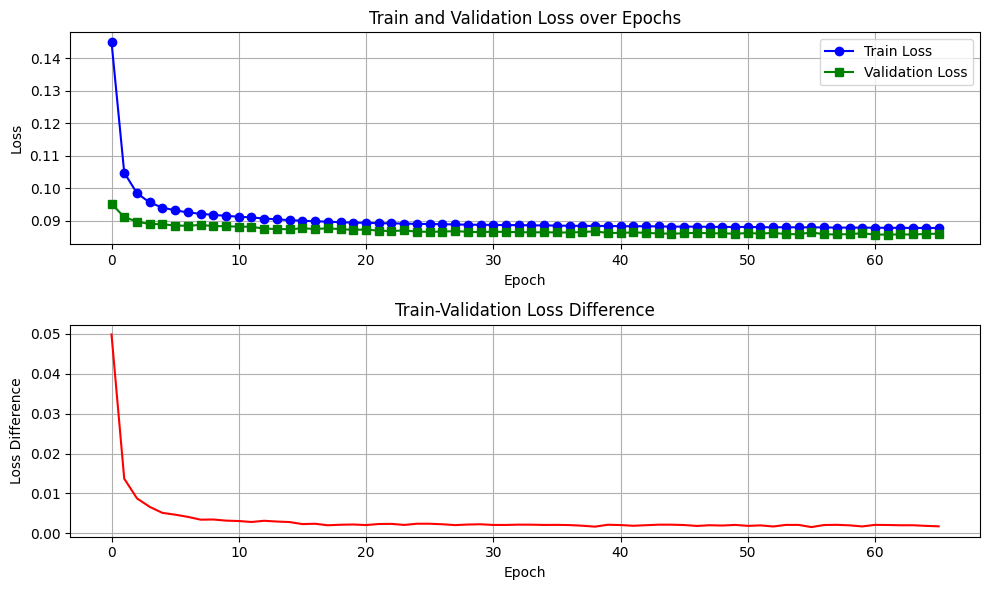

In [23]:
epochs = range(len(train_losses))  # Create x-axis for epochs

loss_diff = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

plt.figure(figsize=(10, 6))  # Set plot size

plt.subplot(2, 1, 1)  # Create subplot for main plot
plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='b')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', color='g')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Difference plot
plt.subplot(2, 1, 2)  # Create subplot for difference plot
plt.plot(epochs, loss_diff, label='Difference', color='r')

plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.title('Train-Validation Loss Difference')
plt.grid(True)

plt.tight_layout()  # Adjust layout for subplots
plt.show()

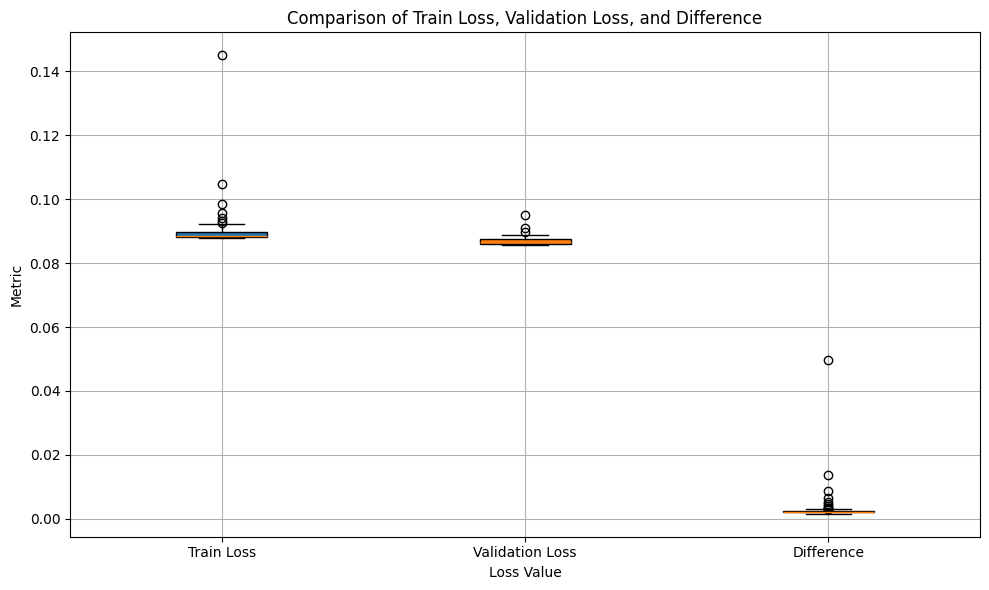

In [24]:
# Create the box plots
fig, ax = plt.subplots(figsize=(10, 6))

bp1 = ax.boxplot([train_losses, val_losses, loss_diff], vert=True, patch_artist=True, labels=["Train Loss", "Validation Loss", "Difference"])

# Customize the plot
plt.xlabel("Loss Value")
plt.ylabel("Metric")
plt.title("Comparison of Train Loss, Validation Loss, and Difference")
plt.grid(True)

# Customize colors and styles
colors = ["tab:blue", "tab:orange", "tab:purple"]
for box, color in zip(bp1["boxes"], colors):
    box.set_facecolor(color)

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()   # To remove channel dimension which is 1

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


For network training we normalized the data by subtracting the mean and dividing by the standard deviation. To evaluate the predictions, we now need to un-normalize the data using the mean and standard deviation we used to normalize it. Then we can compute the RMSE of the predictions. 

In [26]:
# Unnormalize
pred_test = pred_test * std + mean
# compute RMSE
computed_weighted_rmse(pred_test, target.isel(time=slice(lead_time_steps, None)))

<xarray.DataArray ()>
array(837.2331079)
Coordinates:
    level    int32 500

How does the skill compare to the climatology?

It is always important to visualize your models predictions. Here we take a time from the test period and visualize the ground truth, the climatology and the neural networks' predictions. What do you notice? How about if you try a different time?

/tmp/ipykernel_13586/2304207596.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  t = xr.DataArray(np.datetime64('2017-10-01T00'))


Text(0.5, 1.0, 'Prediction')

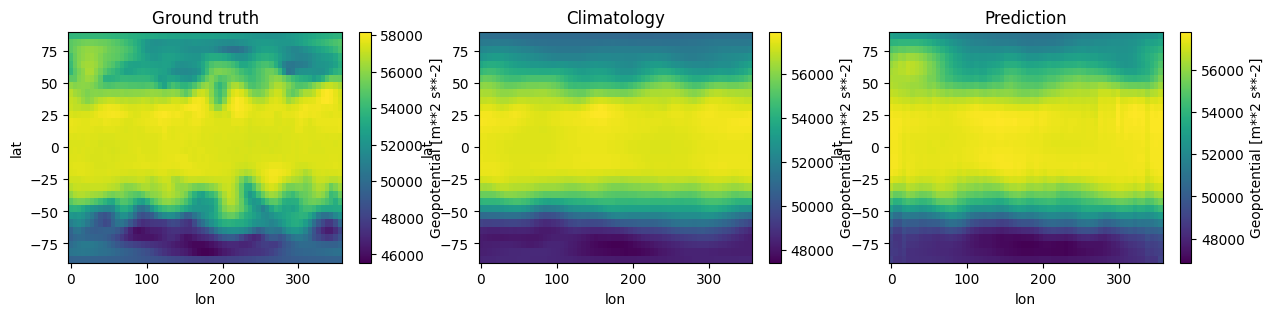

In [27]:
# Note first you need to modify your predictions so they are an xarray instead of a numpy array
# This way you can access the latitude, longitude and time for each point in the array

# We do this by taking a copy of the original z500 object which has the correct time, 
# latitude and longitude, and replacing the data in this array with the predictions
pred_xarray = z500.z.sel(time=test_years).isel(time=slice(lead_time_steps, None)).copy()
pred_xarray.data = pred_test

import matplotlib.pyplot as plt

t = xr.DataArray(np.datetime64('2017-10-01T00'))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

z500.z.sel(time=t).plot(ax=ax1)
ax1.set_title('Ground truth')

clim.z.sel(dayofyear=t.dt.dayofyear).plot(ax=ax2)
ax2.set_title('Climatology')

pred_xarray.sel(time=t).plot(ax=ax3)
ax3.set_title('Prediction')

The prediction is a lot smoother compared to the ground truth, almost as smooth as climatology. 

## Ideas and Additional Exercises

The model we built isn't particularly good. How could we make it better? Here are some ideas to try.

- Make the neural net bigger/smaller? 

  We provide the following function for you to easily construct a neural network with more layers:

```
def build_model_cnn(no_of_layers):
    """Fully convolutional network"""
    x = input = keras.layers.Input(shape=(32, 64, 1))
    x = Conv2D(64, 5, padding = 'same')(x)    
    for i in range(no_of_layers):
        x = Conv2D(64, 5, padding = 'same')(x)
        x = tf.keras.layers.Activation('ReLU')(x)
    output = Conv2D(1, 5, padding = 'same')(x)
    model = tf.keras.models.Model(input, output)
    model.compile(keras.optimizers.Adam(1e-4), 'mse')
    print(model.summary())
    return model
```

- Add more variables, for example 850hPa temperature, which is available, check: https://github.com/pangeo-data/WeatherBench
- Currently, the convolutions do not wrap around the Earth. You could implement periodic convolutions, see [here](https://github.com/pangeo-data/WeatherBench/blob/master/src/train_nn.py#L102). 